# Chest X-Ray Medical Diagnosis with Deep Learning

## Imports

In [68]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

In [69]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.17.0')

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [71]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Paths Setup

In [72]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.IMAGES_DIR)

datasets/images-small/


In [73]:
IMAGE_DIR = Path(cfg.DATASET_DIRS.IMAGES_DIR)
TRAIN_CSV = Path(cfg.DATASET_DIRS.TRAIN_CSV)
VALID_CSV = Path(cfg.DATASET_DIRS.VALID_CSV)
TEST_CSV = Path(cfg.DATASET_DIRS.TEST_CSV)

IMAGE_SIZE = cfg.TRAIN.IMG_SIZE

## Load the Datasets
[ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.

### Loading the Data

In [74]:
train_df = pd.read_csv(f"{TRAIN_CSV}")
valid_df = pd.read_csv(f"{VALID_CSV}")

test_df = pd.read_csv(f"{TEST_CSV}")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   int64 
dtypes: int64(15), object(1)
m

In [76]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               109 non-null    object
 1   Atelectasis         109 non-null    int64 
 2   Cardiomegaly        109 non-null    int64 
 3   Consolidation       109 non-null    int64 
 4   Edema               109 non-null    int64 
 5   Effusion            109 non-null    int64 
 6   Emphysema           109 non-null    int64 
 7   Fibrosis            109 non-null    int64 
 8   Hernia              109 non-null    int64 
 9   Infiltration        109 non-null    int64 
 10  Mass                109 non-null    int64 
 11  Nodule              109 non-null    int64 
 12  PatientId           109 non-null    int64 
 13  Pleural_Thickening  109 non-null    int64 
 14  Pneumonia           109 non-null    int64 
 15  Pneumothorax        109 non-null    int64 
dtypes: int64(15), object(1)
me

In [78]:
valid_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00027623_007.png,0,0,0,1,1,0,0,0,0,0,0,27623,0,0,0
1,00028214_000.png,0,0,0,0,0,0,0,0,0,0,0,28214,0,0,0
2,00022764_014.png,0,0,0,0,0,0,0,0,0,0,0,22764,0,0,0
3,00020649_001.png,1,0,0,0,1,0,0,0,0,0,0,20649,0,0,0
4,00022283_023.png,0,0,0,0,0,0,0,0,0,0,0,22283,0,0,0


In [77]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               420 non-null    object
 1   PatientId           420 non-null    int64 
 2   Cardiomegaly        420 non-null    int64 
 3   Emphysema           420 non-null    int64 
 4   Effusion            420 non-null    int64 
 5   Hernia              420 non-null    int64 
 6   Infiltration        420 non-null    int64 
 7   Mass                420 non-null    int64 
 8   Nodule              420 non-null    int64 
 9   Atelectasis         420 non-null    int64 
 10  Pneumothorax        420 non-null    int64 
 11  Pleural_Thickening  420 non-null    int64 
 12  Pneumonia           420 non-null    int64 
 13  Fibrosis            420 non-null    int64 
 14  Edema               420 non-null    int64 
 15  Consolidation       420 non-null    int64 
dtypes: int64(15), object(1)
me

### Total Labels

In [28]:
column_names = list(train_df.columns)
labels = column_names[1:]
labels.remove('PatientId')
labels, len(labels)

(['Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Effusion',
  'Emphysema',
  'Fibrosis',
  'Hernia',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pleural_Thickening',
  'Pneumonia',
  'Pneumothorax'],
 14)

In [29]:
train_df_labels = train_df[labels]
train_df_labels.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Unique Check

In [30]:
train_df.PatientId.count(),train_df.PatientId.nunique()

(1000, 928)

### Dataset Inbalance Check

In [31]:
sorted_df = train_df[labels].sum().sort_values()
sorted_df

Hernia                  2
Pneumonia              10
Emphysema              13
Fibrosis               14
Edema                  16
Cardiomegaly           20
Pleural_Thickening     21
Consolidation          33
Pneumothorax           38
Mass                   45
Nodule                 54
Atelectasis           106
Effusion              128
Infiltration          175
dtype: int64

In [66]:
sorted_df.values

array([  2,  10,  13,  14,  16,  20,  21,  33,  38,  45,  54, 106, 128,
       175])

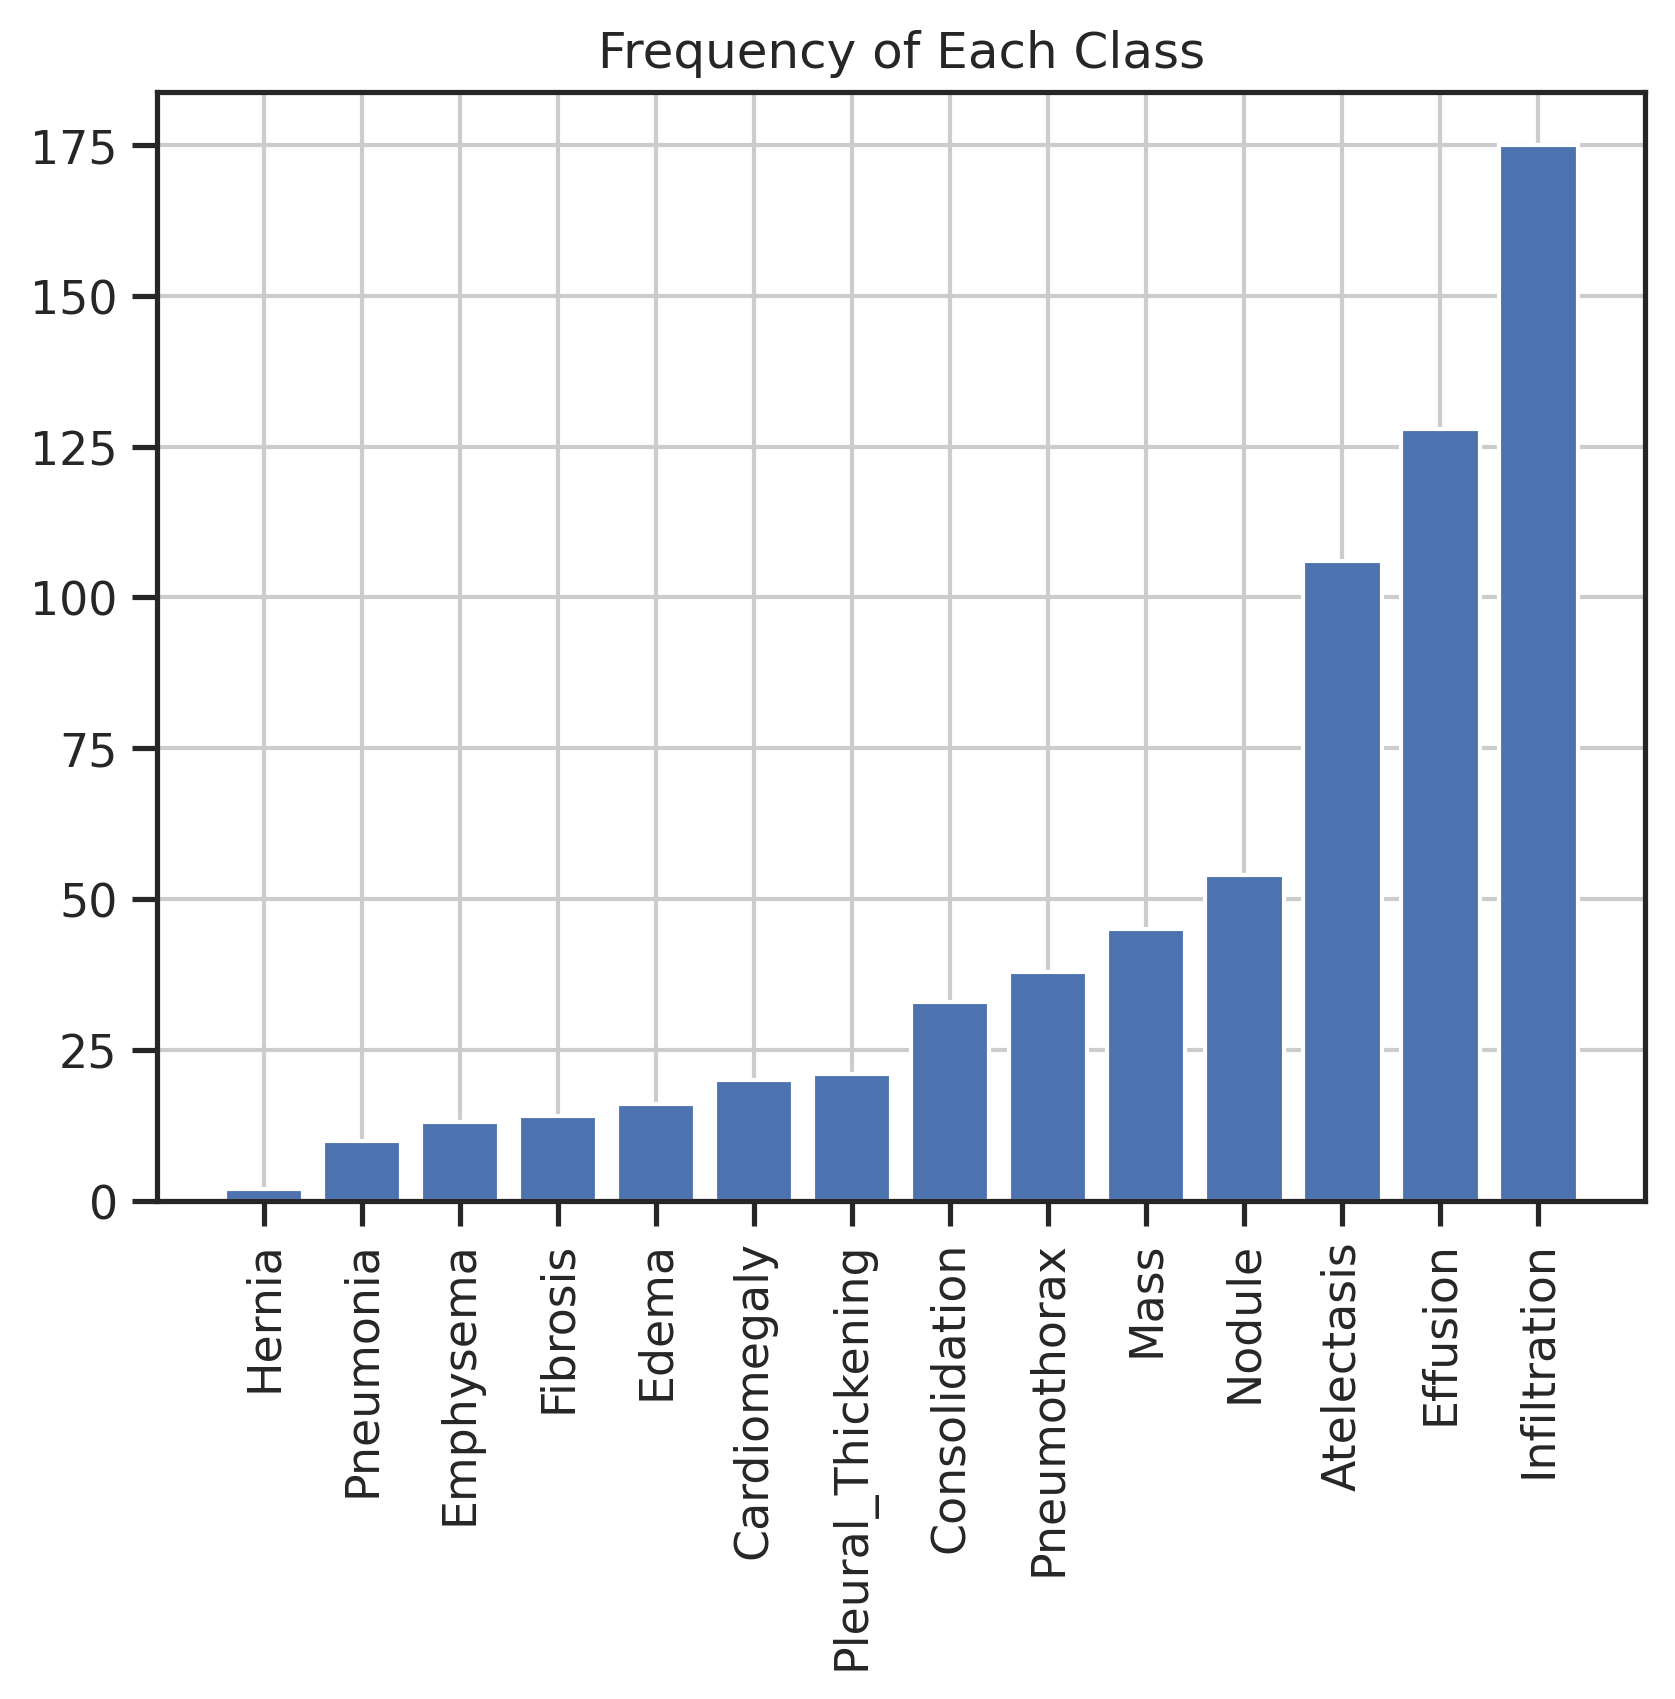

In [67]:
plt.xticks(rotation=90)
plt.bar(x=sorted_df.index, height=(sorted_df.values))
plt.title("Frequency of Each Class")
plt.grid()
plt.show()

## Data Visualization

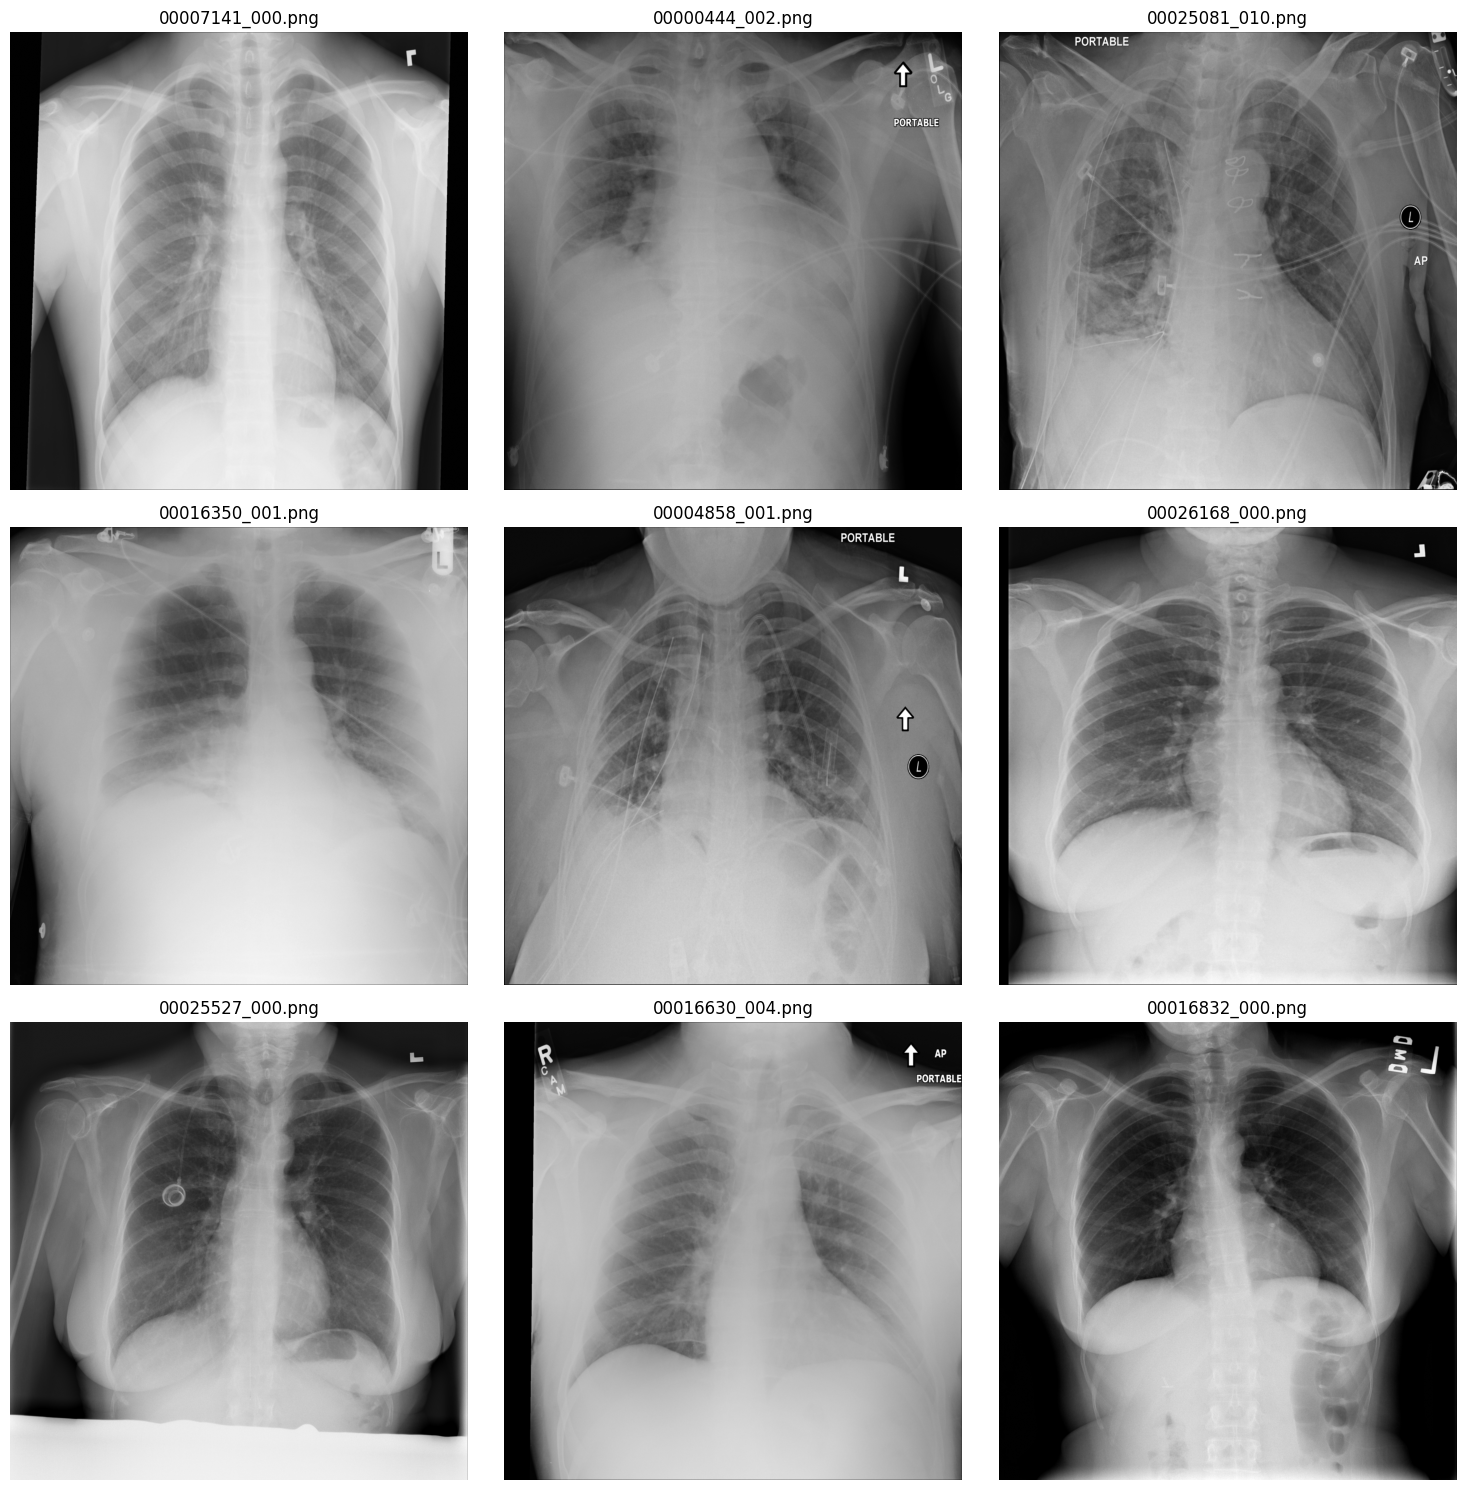

In [39]:
images = train_df.Image.values
IMAGE_NUM = 9
random_images = [np.random.choice(images) for _ in range(IMAGE_NUM)]

plt.figure(figsize=(15, 15))

for i in range(IMAGE_NUM):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(f"{cfg.DATASET_DIRS.IMAGES_DIR}/{random_images[i]}")
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title(random_images[i])
    
plt.tight_layout()
plt.show()

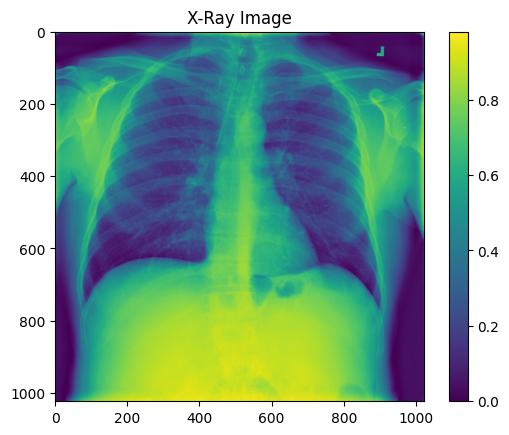

In [33]:
sample_image = train_df.Image[0]
img = plt.imread(f"{cfg.DATASET_DIRS.IMAGES_DIR}/{sample_image}")
plt.imshow(img)
plt.title('X-Ray Image')
plt.colorbar()

In [34]:
img.min(),img.max(), img.mean(),img.std()

(0.0, 0.98039216, 0.47961414, 0.275735)

### Investigating Pixel Value Distribution

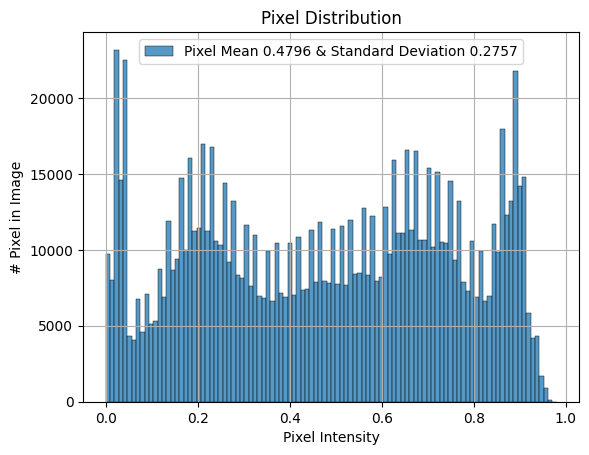

In [35]:
sns.histplot(img.ravel(),
    label=f'Pixel Mean {np.mean(img):.4f} & Standard Deviation {np.std(img):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Pixel Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel in Image')
plt.grid()

In [37]:
def load_image(image_name, label):
    full_path = tf.strings.join([f'{IMAGE_DIR}/', image_name])
    image = tf.io.read_file(full_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])  # Resize to the desired size
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_df.Image.values,  train_df_labels.values))
train_ds = train_ds.map(load_image)

In [38]:
for batch in train_ds.take(1):
    image, label = batch
    print(image, label)

tf.Tensor(
[[[203.48     203.48     203.48    ]
  [194.97     194.97     194.97    ]
  [184.2      184.2      184.2     ]
  ...
  [192.       192.       192.      ]
  [200.63004  200.63004  200.63004 ]
  [212.6003   212.6003   212.6003  ]]

 [[144.91     144.91     144.91    ]
  [120.09     120.09     120.09    ]
  [101.35     101.35     101.35    ]
  ...
  [173.45     173.45     173.45    ]
  [188.31     188.31     188.31    ]
  [201.90022  201.90022  201.90022 ]]

 [[ 86.350006  86.350006  86.350006]
  [ 59.35      59.35      59.35    ]
  [ 41.5       41.5       41.5     ]
  ...
  [126.5      126.5      126.5     ]
  [173.50012  173.50012  173.50012 ]
  [191.2002   191.2002   191.2002  ]]

 ...

 [[ 13.45      13.45      13.45    ]
  [ 10.049999  10.049999  10.049999]
  [  8.         8.         8.      ]
  ...
  [ 13.75      13.75      13.75    ]
  [ 19.25003   19.25003   19.25003 ]
  [ 30.300049  30.300049  30.300049]]

 [[ 14.929998  14.929998  14.929998]
  [ 11.190008  11.190008  

In [56]:
normalized_layer = tf.keras.layers.Normalization()

normalized_layer.adapt(train_ds.map(lambda x, y: x))

train_ds = train_ds.map(lambda x, y: (normalized_layer(x), y))
norm_img = None
for batch in train_ds.take(1):
    image, label = batch
    norm_img = image.numpy()
    print(norm_img.min(), norm_img.max(), norm_img.mean(),norm_img.std())

-1.996185 1.9187149 -0.05869655 1.113249


Generated Image: mean -0.0587 - Standard Deviation 1.1132 
Min pixel value -1.996 - Max pixel value 1.919


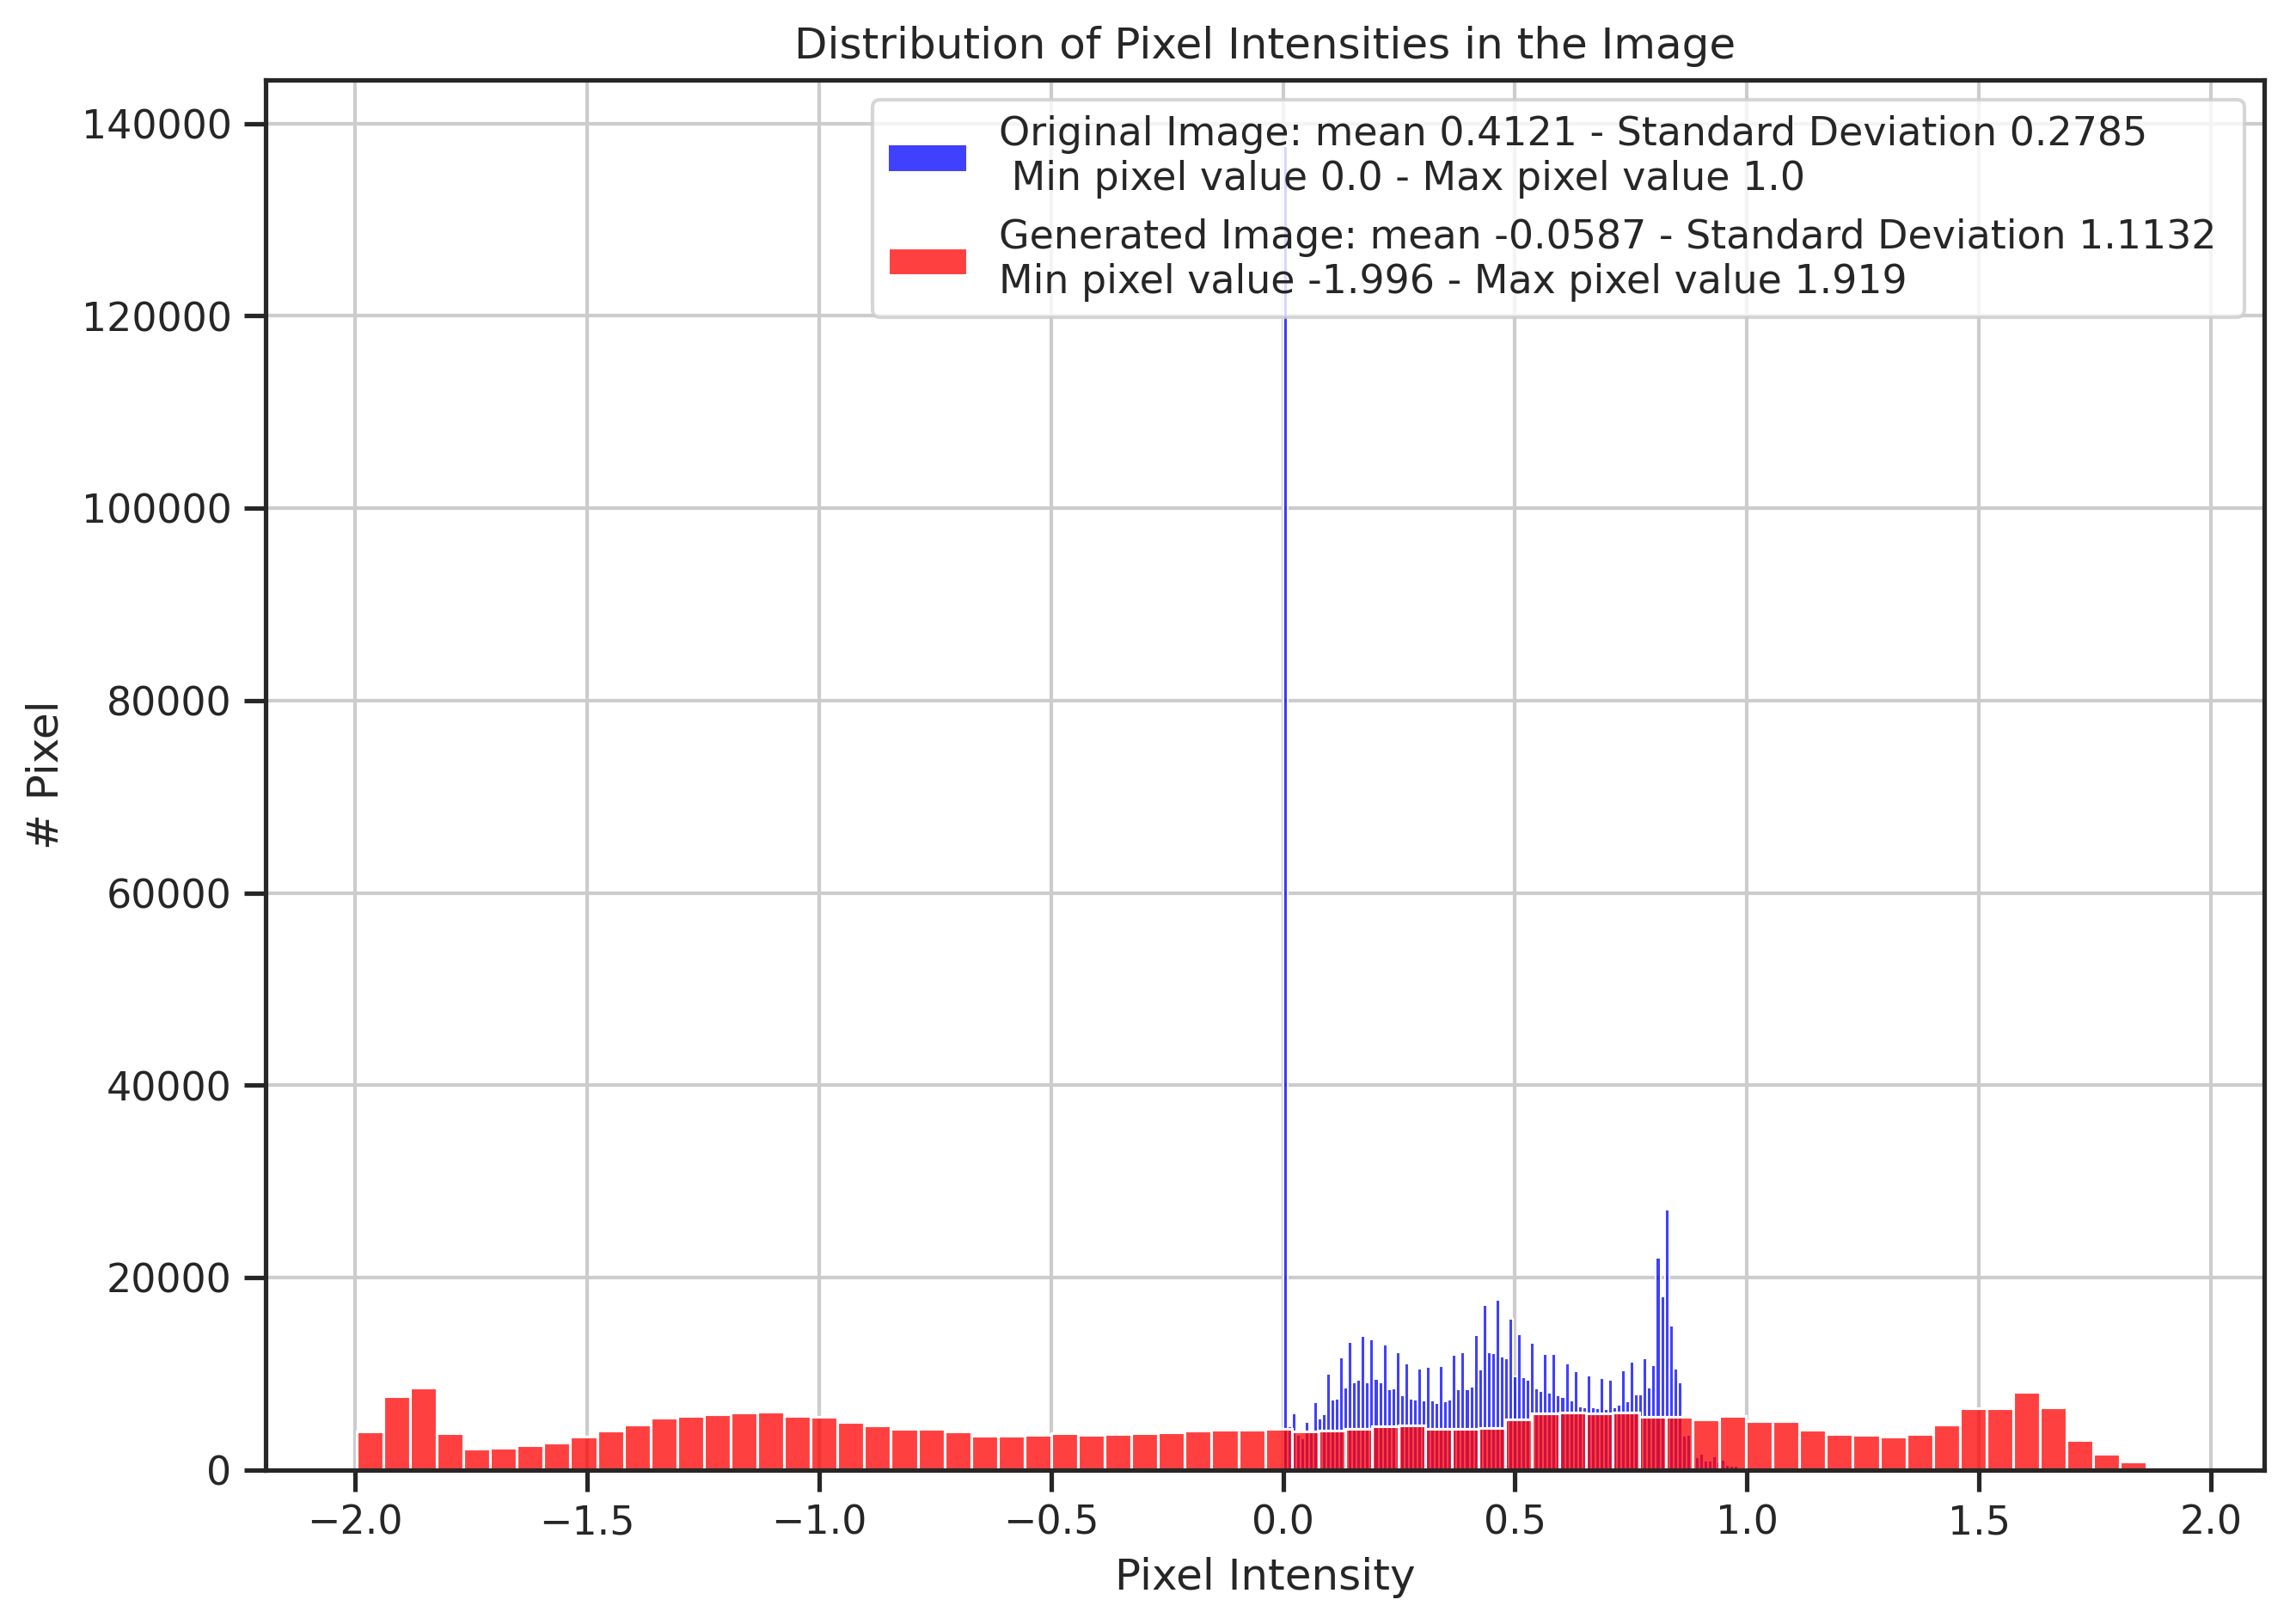

In [63]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
plt.figure(figsize=(10, 7))

sns.histplot(img.ravel(), 
             label=f'Original Image: mean {np.mean(img):.4f} - Standard Deviation {np.std(img):.4f} \n '
             f'Min pixel value {np.min(img):.4} - Max pixel value {np.max(img):.4}',
             color='blue', 
             kde=False)

# Plot histogram for generated image
sns.histplot(norm_img.ravel(), 
             label=f'Generated Image: mean {np.mean(norm_img):.4f} - Standard Deviation {np.std(norm_img):.4f} \n'
             f'Min pixel value {np.min(norm_img):.4} - Max pixel value {np.max(norm_img):.4}', 
             color='red', 
             kde=False)

plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.grid()
print(f'Generated Image: mean {np.mean(norm_img):.4f} - Standard Deviation {np.std(norm_img):.4f} \n'
             f'Min pixel value {np.min(norm_img):.4} - Max pixel value {np.max(norm_img):.4}')